In [5]:
import glob 
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


tf.config.run_functions_eagerly(True)



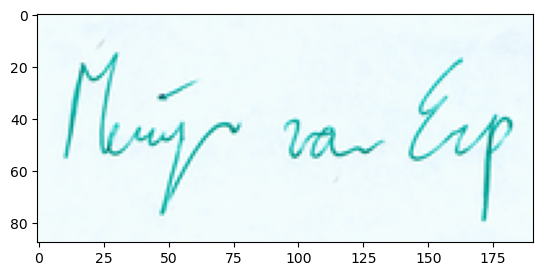

In [3]:
# проверка

genuine = [glob.glob('Dataset_Signature_Final/Dataset/dataset1/real/*.*')]
img = plt.imread(genuine[0][0])

plt.imshow(img)

720
720


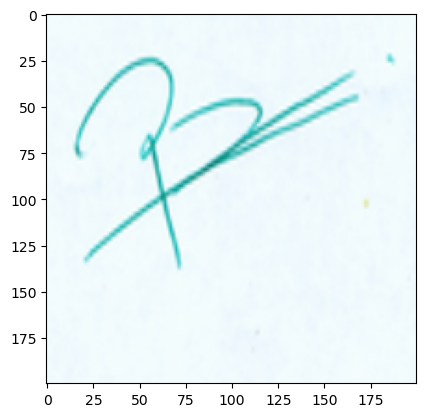

In [4]:
dataset_dir = os.path.abspath('Dataset_Signature_Final/Dataset')

IMAGE_SIZE = 200

images = []
labels = []

for dataset_folder in os.listdir(dataset_dir):
    dataset_path = os.path.join(dataset_dir, dataset_folder)
    if os.path.isdir(dataset_path):
        real_dir = os.path.join(dataset_path, 'real')
        forged_dir = os.path.join(dataset_path, 'forge')

        for image_path in os.listdir(real_dir):
            img = cv2.imread(os.path.join(real_dir, image_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
            images.append(img_to_array(img))
            labels.append(0)  # genuine лейбл

        for image_path in os.listdir(forged_dir):
            img = cv2.imread(os.path.join(forged_dir, image_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
            images.append(img_to_array(img))
            labels.append(1)  # forged лейбл

images = np.array(images) / 255.0  # Нормализация значений пикселей
labels = np.array(labels) # на выходе будет 0 - genuine, 1 - forged

print(len(images))
print(len(labels))
plt.imshow(images[20])

In [9]:
earlyStopping = EarlyStopping(monitor='loss', min_delta=0, patience=4, verbose=1)
early_stop=[earlyStopping]

In [12]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
for layer in vgg16.layers:
    layer.trainable = False

metrics = []

i = 1
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kfold.split(images, labels):
    result = 0

    
    model = Sequential()
    data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
    model.add(vgg16)
    model.add(Flatten(input_shape=vgg16.output_shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=1e-4), 
        metrics=[
            'accuracy', 
            'mean_absolute_percentage_error', 
            'mean_absolute_error', 
            'mean_squared_error'])
    

    # model.summary()

    x_train, x_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    result = model.fit(x_train, y_train, batch_size=32,epochs=10, callbacks=early_stop)
    i += 1
    model.save(f"CNN-fold-{i}.keras")

    metrics_fold = {
        "Train Accuracy" : result.history['accuracy'],
        "Train MAPE" : result.history['mean_absolute_percentage_error'],
        "Train MAE" : result.history['mean_absolute_error'],
        "Train MSE" : result.history['mean_squared_error'],
        "Train Loss" : result.history['loss'],
    }
    metrics.append(result.history)


Epoch 1/10


c:\Users\minichazer\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


18/18 [==============================] - 113s 6s/step - loss: 0.8358 - accuracy: 0.5260 - mean_absolute_percentage_error: 240535040.0000 - mean_absolute_error: 0.4811 - mean_squared_error: 0.2981
Epoch 2/10
18/18 [==============================] - 116s 6s/step - loss: 0.5603 - accuracy: 0.7205 - mean_absolute_percentage_error: 188900928.0000 - mean_absolute_error: 0.3778 - mean_squared_error: 0.1897
Epoch 3/10
18/18 [==============================] - 118s 7s/step - loss: 0.3955 - accuracy: 0.8420 - mean_absolute_percentage_error: 147350784.0000 - mean_absolute_error: 0.2947 - mean_squared_error: 0.1232
Epoch 4/10
18/18 [==============================] - 117s 7s/step - loss: 0.3008 - accuracy: 0.9028 - mean_absolute_percentage_error: 115594880.0000 - mean_absolute_error: 0.2312 - mean_squared_error: 0.0856
Epoch 5/10
18/18 [==============================] - 114s 6s/step - loss: 0.2447 - accuracy: 0.9271 - mean_absolute_percentage_error: 95333144.0000 - mean_absolute_error: 0.1907 - mean

In [52]:
metrics_avg = {
    'loss': 0,
    'accuracy': 0,
    'mean_absolute_percentage_error': 0,
    'mean_absolute_error': 0,
    'mean_squared_error': 0,

}
for i in range(5):
    
    model_fold = keras.models.load_model(f'CNN-fold-{i+1}.keras')
    evaluation = model_fold.evaluate(x_test, y_test, batch_size=32)
    metric_names = model.metrics_names
    print(f"Результат тестовой выборки фолда №{i+1}:")
    for metric, result in zip(metric_names, evaluation):
        print(f"{metric}: {result}")
        metrics_avg[metric] += (result / 5)

metrics_avg

c:\Users\minichazer\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5/5 [==============================] - 8s 2s/step - loss: 0.0777 - accuracy: 0.9931 - mean_absolute_percentage_error: 35031100.0000 - mean_absolute_error: 0.0701 - mean_squared_error: 0.0120
Результат тестовой выборки фолда №1:
loss: 0.07771200686693192
accuracy: 0.9930555820465088
mean_absolute_percentage_error: 35031100.0
mean_absolute_error: 0.07006220519542694
mean_squared_error: 0.012005070224404335
5/5 [==============================] - 9s 2s/step - loss: 0.0931 - accuracy: 0.9792 - mean_absolute_percentage_error: 39986824.0000 - mean_absolute_error: 0.0800 - mean_squared_error: 0.0185
Результат тестовой выборки фолда №2:
loss: 0.09308066964149475
accuracy: 0.9791666865348816
mean_absolute_percentage_error: 39986824.0
mean_absolute_error: 0.07997364550828934
mean_squared_error: 0.018519889563322067
5/5 [==============================] - 10s 2s/step - loss: 0.0737 - accuracy: 1.0000 - mean_absolute_percentage_error: 33532842.0000 - mean_absolute_error: 0.0671 - mean_squared_error:

{'loss': 0.09822452515363694,
 'accuracy': 0.9861111164093017,
 'mean_absolute_percentage_error': 42255346.800000004,
 'mean_absolute_error': 0.08451069444417954,
 'mean_squared_error': 0.01893280316144228}

In [41]:
import json
json_obj = json.dumps(metrics)
with open('metrics.json', 'w', encoding='utf-8') as f:
    f.write(json_obj)

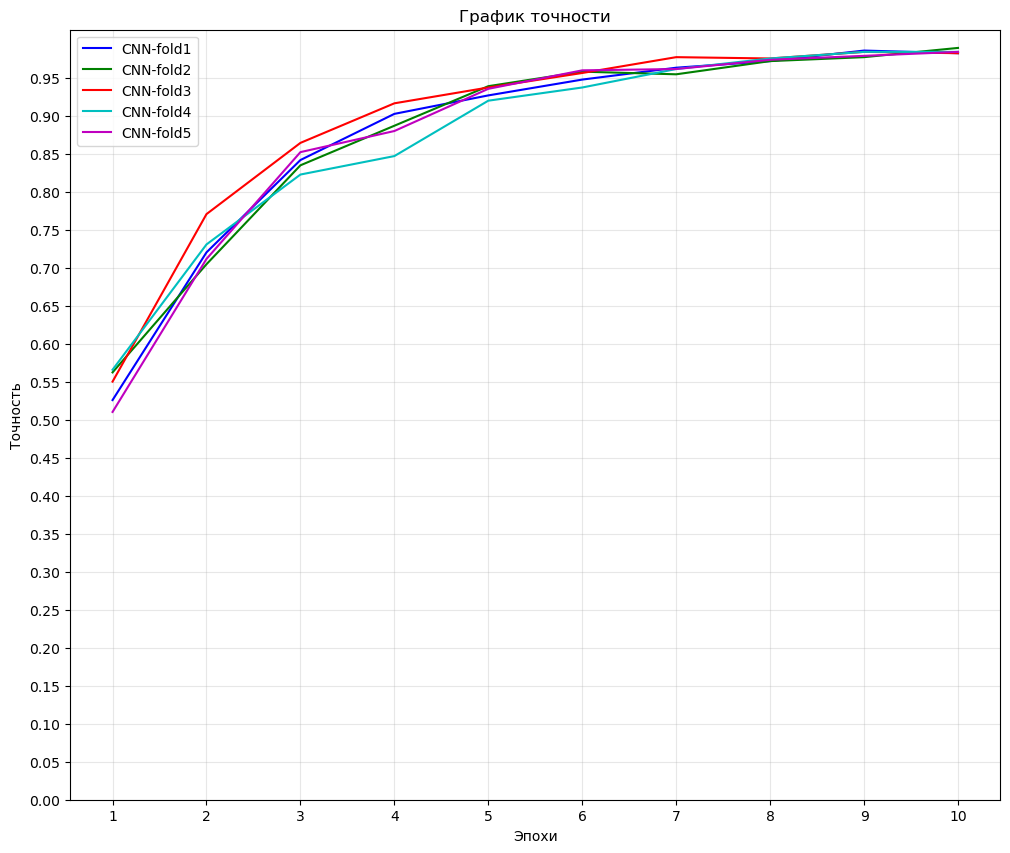

In [54]:
epochs = range(1, 11)
plt.figure(figsize=(12, 10))


plt.plot(epochs, metrics[0]['accuracy'], 'b', label='CNN-fold1')
plt.plot(epochs, metrics[1]['accuracy'], 'g', label='CNN-fold2')
plt.plot(epochs, metrics[2]['accuracy'], 'r', label='CNN-fold3')
plt.plot(epochs, metrics[3]['accuracy'], 'c', label='CNN-fold4')
plt.plot(epochs, metrics[4]['accuracy'], 'm', label='CNN-fold5')
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.yticks(np.arange(0, 1.0, 0.05))
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.grid(alpha=0.3)
plt.title('График точности')
plt.legend()
plt.show()

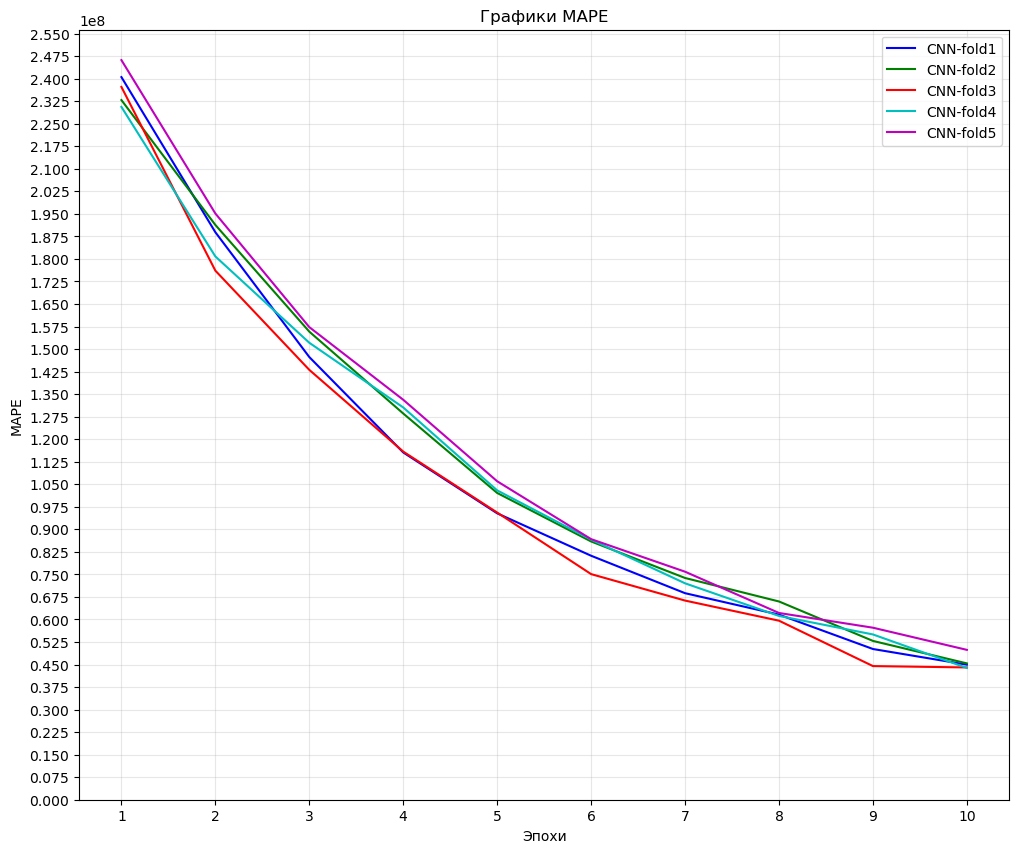

In [56]:
epochs = range(1, 11)
plt.figure(figsize=(12, 10))
plt.plot(epochs, metrics[0]['mean_absolute_percentage_error'], 'b', label='CNN-fold1')
plt.plot(epochs, metrics[1]['mean_absolute_percentage_error'], 'g', label='CNN-fold2')
plt.plot(epochs, metrics[2]['mean_absolute_percentage_error'], 'r', label='CNN-fold3')
plt.plot(epochs, metrics[3]['mean_absolute_percentage_error'], 'c', label='CNN-fold4')
plt.plot(epochs, metrics[4]['mean_absolute_percentage_error'], 'm', label='CNN-fold5')
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.yticks(np.arange(0, 260000000, 7500000))
plt.xlabel('Эпохи')
plt.ylabel('MAPE')
plt.grid(alpha=0.3)
plt.title('Графики MAPE')
plt.legend()
plt.show()

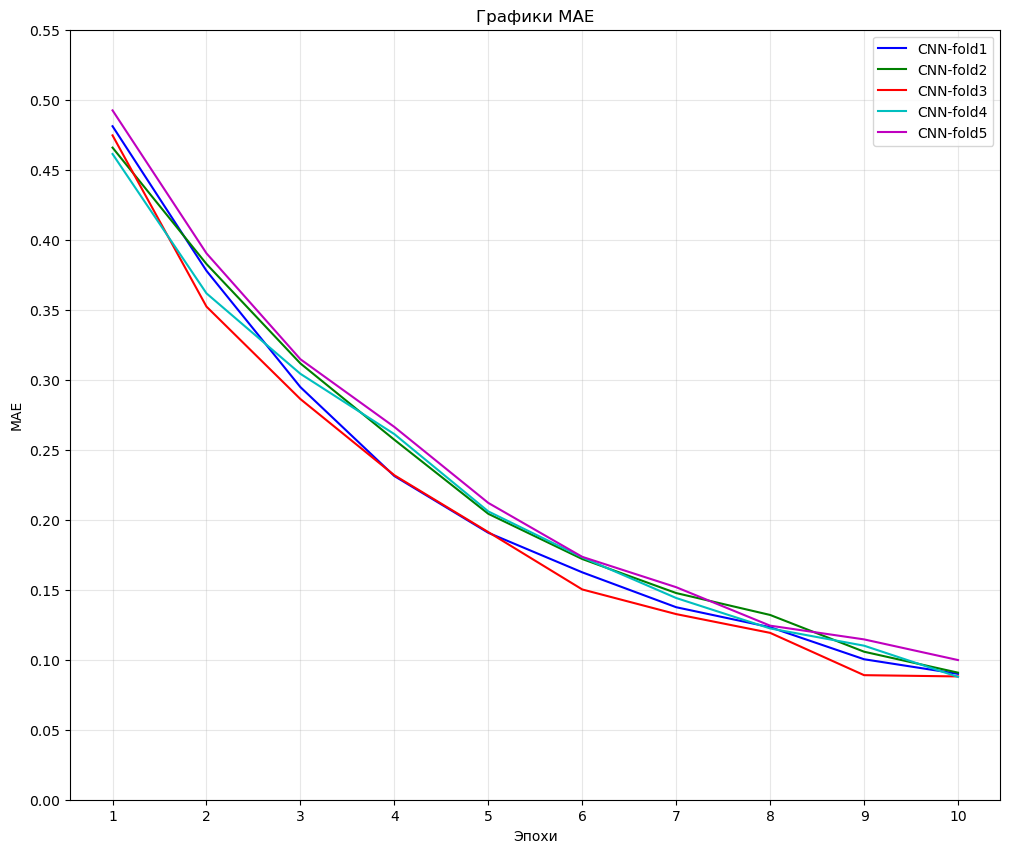

In [60]:
epochs = range(1, 11)
plt.figure(figsize=(12, 10))
plt.plot(epochs, metrics[0]['mean_absolute_error'], 'b', label='CNN-fold1')
plt.plot(epochs, metrics[1]['mean_absolute_error'], 'g', label='CNN-fold2')
plt.plot(epochs, metrics[2]['mean_absolute_error'], 'r', label='CNN-fold3')
plt.plot(epochs, metrics[3]['mean_absolute_error'], 'c', label='CNN-fold4')
plt.plot(epochs, metrics[4]['mean_absolute_error'], 'm', label='CNN-fold5')
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.yticks(np.arange(0, 0.6, 0.05))
plt.xlabel('Эпохи')
plt.ylabel('MAE')
plt.grid(alpha=0.3)
plt.title('Графики MAE')
plt.legend()
plt.show()

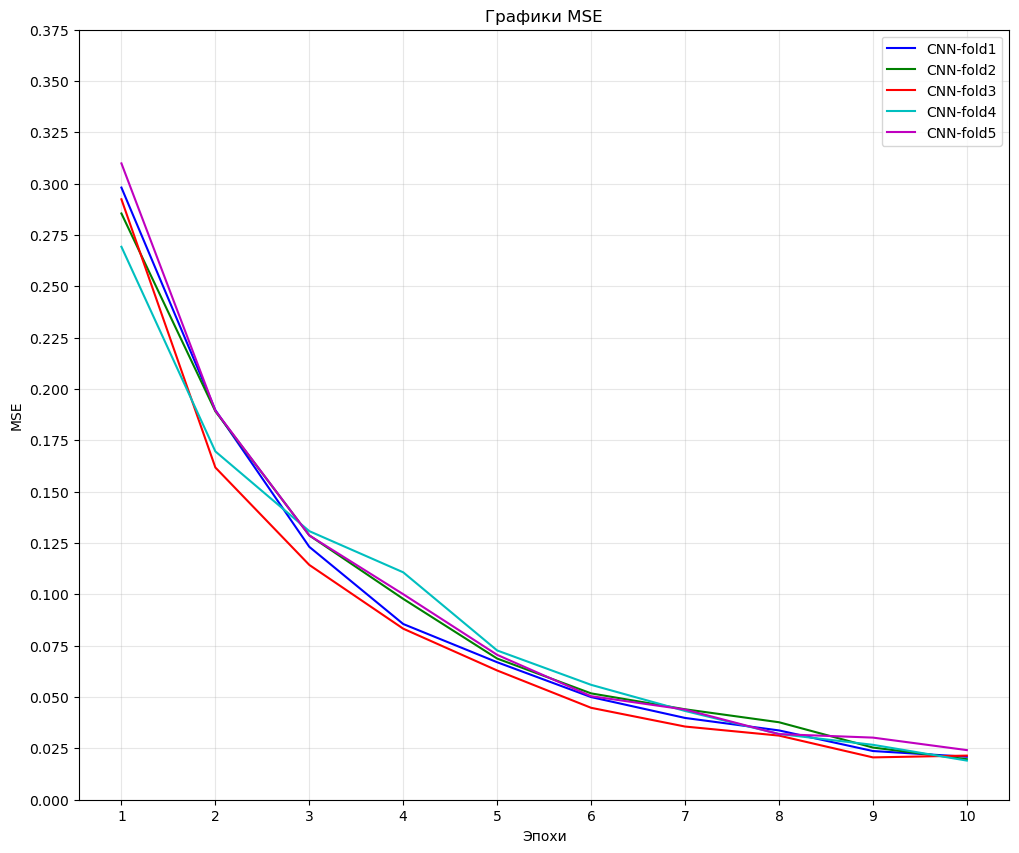

In [61]:
epochs = range(1, 11)
plt.figure(figsize=(12, 10))
plt.plot(epochs, metrics[0]['mean_squared_error'], 'b', label='CNN-fold1')
plt.plot(epochs, metrics[1]['mean_squared_error'], 'g', label='CNN-fold2')
plt.plot(epochs, metrics[2]['mean_squared_error'], 'r', label='CNN-fold3')
plt.plot(epochs, metrics[3]['mean_squared_error'], 'c', label='CNN-fold4')
plt.plot(epochs, metrics[4]['mean_squared_error'], 'm', label='CNN-fold5')
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.yticks(np.arange(0, 0.4, 0.025))
plt.xlabel('Эпохи')
plt.ylabel('MSE')
plt.grid(alpha=0.3)
plt.title('Графики MSE')
plt.legend()
plt.show()

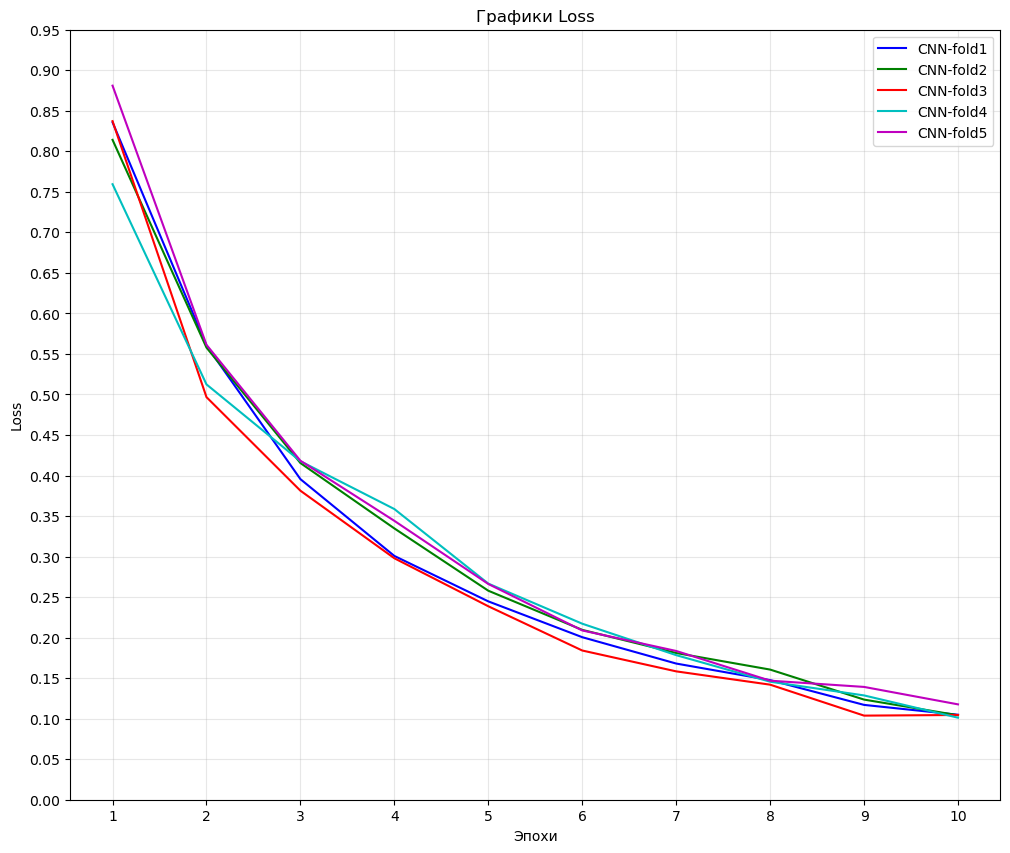

In [62]:
epochs = range(1, 11)
plt.figure(figsize=(12, 10))
plt.plot(epochs, metrics[0]['loss'], 'b', label='CNN-fold1')
plt.plot(epochs, metrics[1]['loss'], 'g', label='CNN-fold2')
plt.plot(epochs, metrics[2]['loss'], 'r', label='CNN-fold3')
plt.plot(epochs, metrics[3]['loss'], 'c', label='CNN-fold4')
plt.plot(epochs, metrics[4]['loss'], 'm', label='CNN-fold5')
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.yticks(np.arange(0, 1, 0.05))
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.title('Графики Loss')
plt.legend()
plt.show()

In [51]:
model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 18432)             0         
                                                                 
 dense_16 (Dense)            (None, 256)               4718848   
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 2)                 514       
                                                                 
Total params: 19,434,050
Trainable params: 4,719,362
Non-trainable params: 14,714,688
_________________________________________________________________
